In [1]:
import cv2
import numpy as np

In [2]:
# loading images
img1 = cv2.imread('./image_data/box1.png')
img2 = cv2.imread('./image_data/box2.png')

# Brute Force with SIFT

In [3]:
sift = cv2.SIFT_create() # initializing SIFT detector

In [4]:
# find the keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [5]:
# find matches using k nearest neighbours
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

In [6]:
# apply ratio test to threshold the best matches
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

In [7]:
# draw matches
img3 = cv2.drawMatchesKnn(
    img1,
    kp1,
    img2,
    kp2,
    good,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

In [8]:
# using cv2 for displaying the image
window_name = 'Feature Matching'
cv2.imshow(window_name, img3)

# waits for users to press any key
# (this is necessary to avoid Python kernel from crashing)
cv2.waitKey(0)

-1

# Brute Force with ORB (binary) descriptors

In [9]:
# initialize the ORB descriptor
orb = cv2.ORB_create()

In [10]:
# find keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

In [11]:
"""
Because ORB is a binary descriptor, we find matches using Hamming Distance,
which is a measure of the difference between two strings of equal length.
"""
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [12]:
# find matches
matches = bf.match(des1, des2)

In [13]:
# sort matches in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

In [15]:
# define number of matches (n)
n = 15

In [16]:
# draw first n matches
img3 = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    matches[:n],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

In [17]:
cv2.imshow(window_name, img3)
cv2.waitKey(0)

-1

# Fast Library for Approximation Nearest Neighbours (FLANN)

In [18]:
# create a dictionary to specify the algorithm we will use
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)

In [19]:
# ORB parameters
FLANN_INDEX_LSH = 6
index_params = dict(
    algorithm=FLANN_INDEX_LSH, table_number=12, key_size=20, multi_probe_level=2
)

In [20]:
# create a dictionary to specify the maximum leafs to visit
search_params = dict(checks=50)

In [21]:
# initiate SIFT detector
sift = cv2.SIFT_create()

In [22]:
# find the keypoints and descriptor with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [23]:
# define the FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

In [24]:
# draw only good matches (create mask)
matchesMask = [[0, 0] for i in range(len(matches))]

In [25]:
# perform a ratio test to determine good matches
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

In [27]:
# visualize the matches
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=(255, 0, 0),
    matchesMask=matchesMask,
    flags=cv2.DrawMatchesFlags_DEFAULT,
)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

In [28]:
cv2.imshow(window_name, img3)
cv2.waitKey(0)

-1

# Local Feature Matching with Transformers (LoFTR)

In [29]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [31]:
# load and resize the images
from kornia.feature import LoFTR

img1 = K.io.load_image('./image_data/box1.png', K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image('./image_data/box2.png', K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)

In [32]:
# indicate whether the image is an "indoor" or "outdoor" image
matcher = LoFTR(pretrained="outdoor")

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to C:\Users\ahsam/.cache\torch\hub\checkpoints\loftr_outdoor.ckpt
100.0%


In [33]:
# LoFTR only works on grayscale images, convert the images to grayscale
input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

In [34]:
# perform the inference
with torch.inference_mode():
    correspondences = matcher(input_dict)

In [35]:
# clean up the correspondences using Random Sample Consensus (RANSAC)
# this is helps to deal with noise or outliers in the data

mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

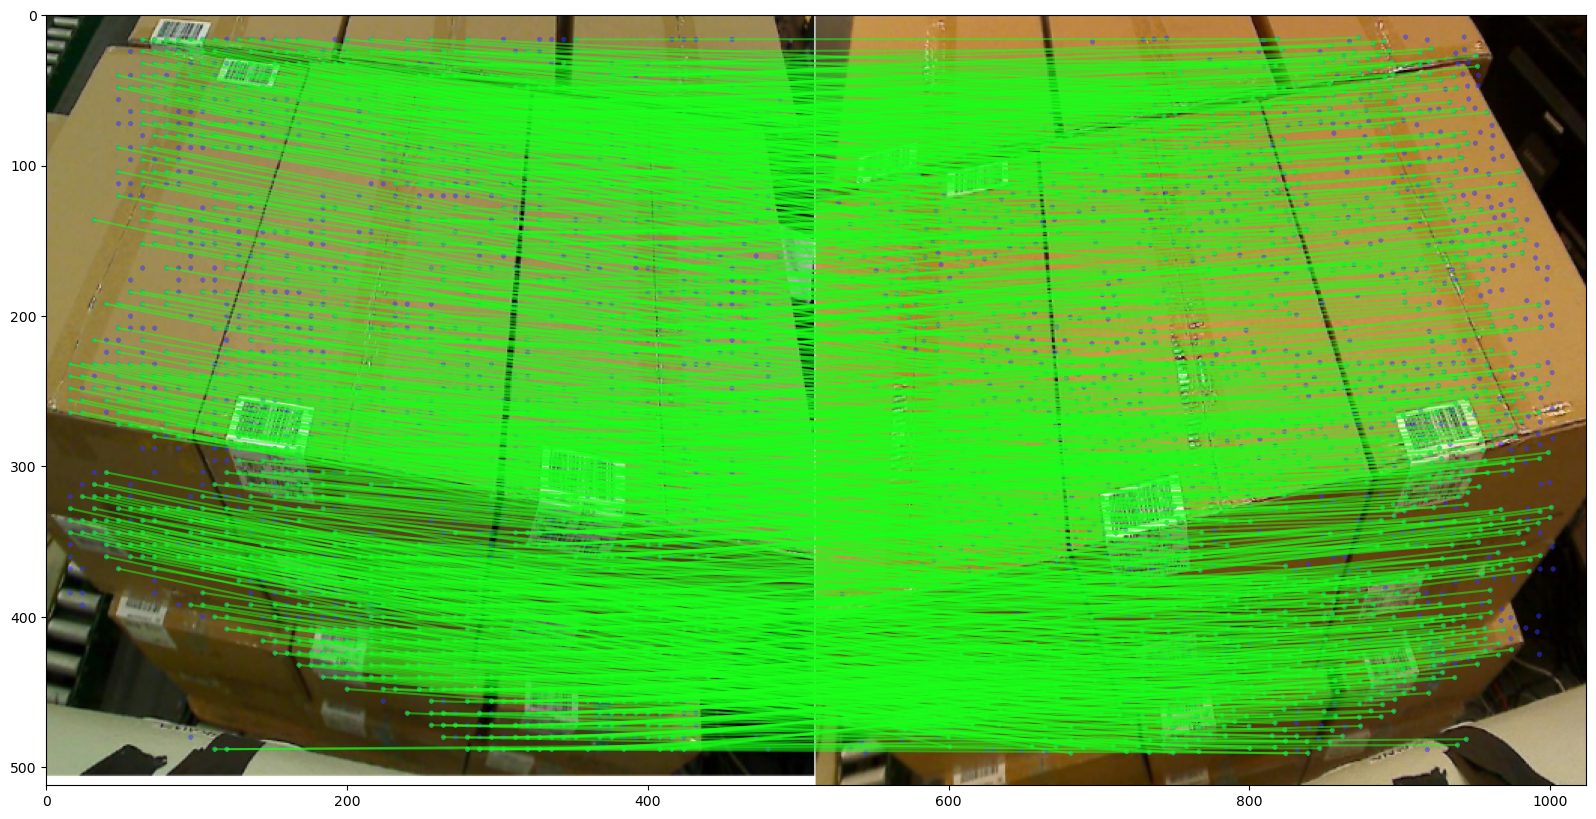

In [36]:
# visualize the matches
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        'inlier_color': (0.1, 1, 0.1, 0.5),
        'tentative_color': None,
        'feature_color': (0.2, 0.2, 1, 0.5),
        'vertical': False,
    },
)